# Bilbiotecas


In [1]:

import os
import re
import time
import string
import tempfile
import numpy as np
import pandas as pd
import statistics as st
from collections import Counter
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Image
from reportlab.lib import colors
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay
import pickle
import emoji
import spacy
import pdfplumber
import fitz  
import contractions
from contractions import fix
from ftfy import fix_text
import wordninja
from deep_translator import GoogleTranslator
from spellchecker import SpellChecker
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, words as nltk_words,  wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pywsd.lesk import simple_lesk
from textblob import TextBlob
import nltk
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from tensorflow.keras.models import Model
from scipy.stats import spearmanr, pearsonr, skew, kendalltau, norm
from statistics import mode, mean
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ParameterGrid
from sklearn.metrics import (confusion_matrix, accuracy_score, classification_report,
                             f1_score, precision_score, recall_score, roc_auc_score, make_scorer)
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight, compute_class_weight, compute_sample_weight
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from joblib import Parallel, delayed
import joblib
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate, Flatten
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from keras.models import load_model
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Embedding, Conv1D, MaxPooling1D, Flatten,
                                     Dense, Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

import optuna
from transformers import (pipeline, RobertaTokenizerFast, RobertaForSequenceClassification,
                          Trainer, TrainingArguments, EarlyStoppingCallback)
from datasets import Dataset
from pyannote.audio import Pipeline as PyannotePipeline


from tkinter import filedialog
from docx import Document
from tqdm import tqdm
import warnings

#!pip install wordcloud
#nltk.download('all')
#nltk.download('stopwords')
#!python -m spacy download pt_core_news_lg
#nltk.download("wordnet")
#nltk.download("averaged_perceptron_tagger")
#nltk.download("punkt")

Warming up PyWSD (takes ~10 secs)... took 7.456454515457153 secs.


In [2]:
def avaliar_modelo(y_test, pred_test, y_val, pred_val):
    def calcular_metricas(y_true, y_pred):
        return {
            'Accuracy': round(accuracy_score(y_true, y_pred), 4),
            'F1-Score': round(f1_score(y_true, y_pred, average='weighted'), 4),
            'Recall': round(recall_score(y_true, y_pred, average='weighted'), 4),
            'Precision': round(precision_score(y_true, y_pred, average='weighted'), 4)
        }
    test_metrics = calcular_metricas(y_test, pred_test)
    val_metrics = calcular_metricas(y_val, pred_val)
    df_resultados = pd.DataFrame([test_metrics, val_metrics], index=['Teste', 'Validação'])
    return df_resultados

In [3]:
def grafico(a):
    if a == 1:
        custom_params = {"axes.spines.right": False, "axes.spines.top": False}
        sns.set_theme(style="ticks", rc=custom_params, palette = "pastel")
        palette = "pastel"
    elif a == 2:
        sns.set_theme(style="white", palette = "Set2")
        palette = "Set2"
    elif a == 3:
        sns.set_theme(style="whitegrid", palette = "pastel")
        palette = "pastel"
    elif a == 4:
        sns.set_theme()
        palette = "husl"
    return palette

# Replicação do estudo

In [4]:
data = pd.read_csv(r"Dataset\AffectAlchemytest2.csv", encoding='ISO-8859-1')
data

,Text,Emotion,en
0,Each day brought with it new challenges as the...,Grief,en
1,Each day brought with it new challenges as the...,Grief,en
2,Each day brought with it new challenges as the...,Grief,en
3,Each day felt heavier than the last as they st...,Grief,en
4,"Every corner of the room reminded him of her,...",Grief,en
...,...,...,...
20070,"So all the m&m's eaten, house neatly decorated...",Surprise,en
20071,"Son is back home, I still have to wrap a prese...",Surprise,en
20072,Son made a super cool one. Can't put it on Twi...,Surprise,en
20073,"So the Sinterklaas presents have been bought, ...",Surprise,en


In [5]:
emocoeslist = {"Sad", "Anger", "Fear", "fear", "sadness", 'Joy'}
data = data[data['Emotion'].isin(emocoeslist)]
data["Emotion"].value_counts()

Emotion
Joy        1723
Sad        1577
Fear       1490
Anger      1043
sadness       3
fear          2
Name: count, dtype: int64

In [6]:
data.loc[:,'Emotion'] = data['Emotion'].replace({'Sad': 'Sadness', 'sadness': 'Sadness',
                                           'Fear': 'Fear', 'fear': 'Fear'})

In [7]:
data["Emotion"].value_counts()

Emotion
Joy        1723
Sadness    1580
Fear       1492
Anger      1043
Name: count, dtype: int64

In [8]:
X = data['Text']
y = data['Emotion']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

In [11]:
model = MultinomialNB()
model.fit(X_train_counts, y_train)

MultinomialNB()

In [12]:
y_pred_test = model.predict(X_test_counts)
y_pred_train = model.predict(X_train_counts)

In [13]:
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred_test)

In [14]:
print(f'Training Accuracy: {accuracy_train:.4f}')
print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test F1 Score: {f1_test:.4f}')
print('Test Confusion Matrix:')
print(conf_matrix)
print('Test Classification Report:')
print(classification_report(y_test, y_pred_test))

Training Accuracy: 0.8891
Test Accuracy: 0.6635
Test F1 Score: 0.6667
Test Confusion Matrix:
[[140  20  31  33]
 [  6 208  27  63]
 [  1  35 235  55]
 [  5  43  74 192]]
Test Classification Report:
              precision    recall  f1-score   support

       Anger       0.92      0.62      0.74       224
        Fear       0.68      0.68      0.68       304
         Joy       0.64      0.72      0.68       326
     Sadness       0.56      0.61      0.58       314

    accuracy                           0.66      1168
   macro avg       0.70      0.66      0.67      1168
weighted avg       0.68      0.66      0.67      1168



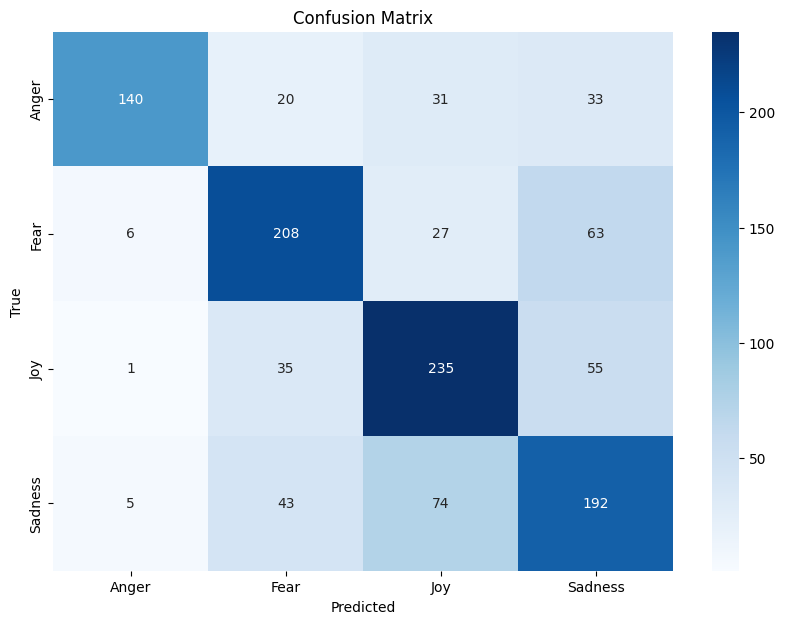

In [15]:
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Tratamento de dados

In [260]:
data = pd.read_csv(r"Dataset\AffectAlchemytest2.csv", encoding='ISO-8859-1')
data

,Text,Emotion,en
0,Each day brought with it new challenges as the...,Grief,en
1,Each day brought with it new challenges as the...,Grief,en
2,Each day brought with it new challenges as the...,Grief,en
3,Each day felt heavier than the last as they st...,Grief,en
4,"Every corner of the room reminded him of her,...",Grief,en
...,...,...,...
20076,"So all the m&m's eaten, house neatly decorated...",Surprise,en
20077,"Son is back home, I still have to wrap a prese...",Surprise,en
20078,Son made a super cool one. Can't put it on Twi...,Surprise,en
20079,"So the Sinterklaas presents have been bought, ...",Surprise,en


Vamos verificar a distribuição de observação de acordo com os nossos labels da variável alvo

In [261]:
data["Emotion"].value_counts()

Emotion
Joy                 1723
Sad                 1577
Fear                1490
Happy               1324
Surprise            1297
Neutral             1220
Peace               1132
Determination       1058
Anger               1043
Gratitude           1030
Disgust             1028
Contempt            1011
Love                1005
Anticipation         969
Awe                  969
Optimism             759
Trust                625
Shame                572
Grief                233
sadness                3
love                   3
Shame,Â Sad            2
Gratitude,Â Love       2
fear                   2
surprise               2
Peace,Â Joy            1
Shame,Â Fear           1
Name: count, dtype: int64

Vamos criar uma coluna com o nome das emoções para podermos apresentar os gráficos com as emoções corretas como referido [anteriormente](#secao6)

In [262]:
emocoeslist = {"Sad", "Anger", "Fear", "fear", "sadness", 'Joy'}
data = data[data['Emotion'].isin(emocoeslist)]
data["Emotion"].value_counts()

Emotion
Joy        1723
Sad        1577
Fear       1490
Anger      1043
sadness       3
fear          2
Name: count, dtype: int64

In [263]:
data.loc[:,'Emotion'] = data['Emotion'].replace({'Sad': 'Sadness', 'sadness': 'Sadness',
                                           'Fear': 'Fear', 'fear': 'Fear'})


In [264]:
data["Emotion"].value_counts()

Emotion
Joy        1723
Sadness    1580
Fear       1492
Anger      1043
Name: count, dtype: int64

C:\Users\garci\AppData\Local\Temp\ipykernel_9764\1215207054.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Emotion", data=data,order= data['Emotion'].value_counts().index,palette="husl")


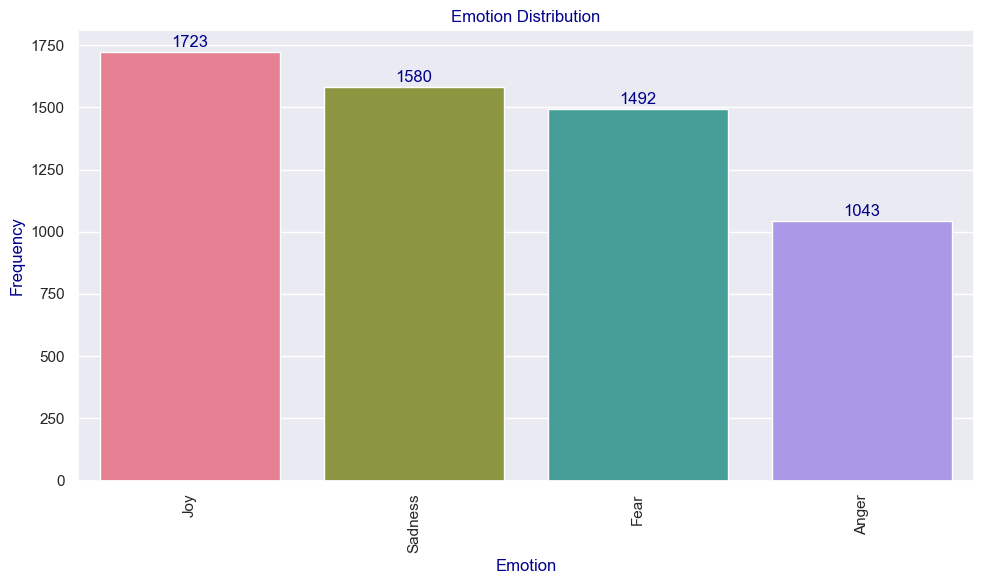

In [265]:
grafico(4)
plt.figure(figsize=(10, 6), dpi=100)
sns.countplot(x="Emotion", data=data,order= data['Emotion'].value_counts().index,palette="husl")
plt.xlabel('Emotion', color="Darkblue")
plt.xticks(rotation=90)
plt.ylabel('Frequency', color='Darkblue')
plt.title('Emotion Distribution', color='Darkblue')
for i, value in enumerate(data['Emotion'].value_counts()):
    plt.text(i, value+20, str(value),ha='center',color='Darkblue')
plt.tight_layout()
plt.show() 

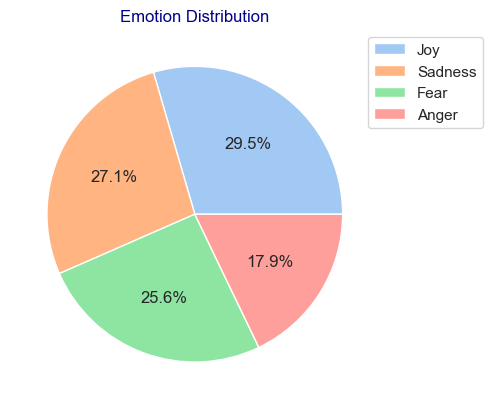

In [266]:
grafico(3)
plt.pie(data['Emotion'].value_counts(), autopct='%1.1f%%')
plt.title('Emotion Distribution', color='Darkblue')
plt.legend(data['Emotion'].value_counts().index, loc='upper right', bbox_to_anchor=(1.3, 1))

In [267]:
pd.DataFrame({'V. Absolutos':data['Emotion'].value_counts(),'V. Relativos (%)':(data['Emotion'].value_counts()*100/data.shape[0]).round(2)})

,V. Absolutos,V. Relativos (%)
Emotion,,
Joy,1723,29.51
Sadness,1580,27.06
Fear,1492,25.56
Anger,1043,17.87


In [268]:
data.to_excel("Dataset\\datasetlimpo4emocoes_EN.xlsx", index=False)

In [269]:
data = pd.read_excel("Dataset\\datasetlimpo4emocoes_EN.xlsx")
data = data[data['Text'].str.strip() != ""]
data

,Text,Emotion,en
0,- great time to think about how to make to our...,Fear,en
1,--- she does wat she want to prove to bitches....,Joy,en
2,!!!1! Merry &amp; a Happy New ! mediale #mindf...,Fear,en
3,""" Don't be cross with Jenny , "" James said alm...",Anger,en
4,"""A betrayal unfolded, leaving behind a bitter ...",Anger,en
...,...,...,...
5833,You're welcome . Did you have a good time on t...,Joy,en
5834,"Youu call it JEALOUSY, I call it of #Losing YO...",Fear,en
5835,YOU'VE PROBABLY HAD DICK FROM 99% OF THE BURTO...,Anger,en
5836,That feeling when your closest friend saw you ...,Sadness,en


In [270]:
textounico = ' '.join(map(str, data['Text']))
len(textounico)

526078

lemma

In [271]:
nlp = spacy.load("en_core_web_lg")
chunk_size = 1000000
chunks = [textounico[i:i + chunk_size] for i in range(0, len(textounico), chunk_size)]
words = []
for chunk in chunks:
    doc = nlp(chunk)
    words.extend([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])
print(f"Total de palavras processadas: {len(words)}")

Total de palavras processadas: 42466


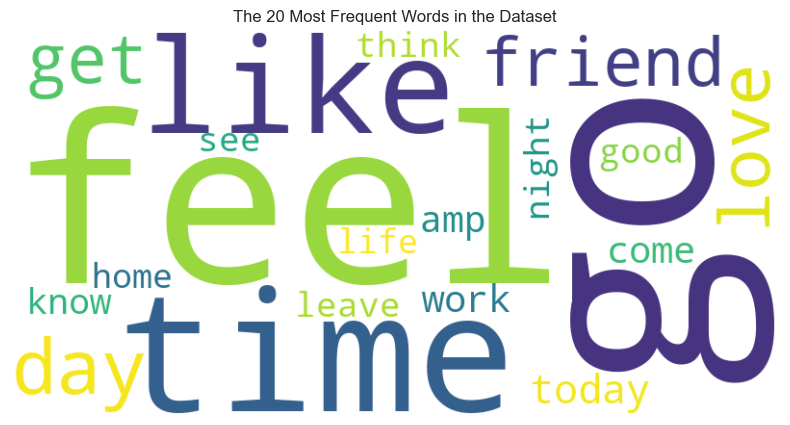

In [272]:
word_frequencies = Counter(words)
top_10_words = dict(word_frequencies.most_common(20))
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate_from_frequencies(top_10_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("The 20 Most Frequent Words in the Dataset")
plt.show()

In [273]:
chunk_size = 1000000
entity_counts = Counter()
chunks = [textounico[i:i + chunk_size] for i in range(0, len(textounico), chunk_size)]
words = []
for chunk in chunks:
    doc = nlp(chunk)
    for ent in doc.ents:
        entity_counts[ent.label_] += 1
total_entities = sum(entity_counts.values())
entity_percentages = {ent: (count / total_entities) * 100 for ent, count in entity_counts.items()}

In [274]:
dfentitycounts = pd.DataFrame.from_dict(entity_counts, orient='index', columns=['Valores Absolutos'])
total = dfentitycounts['Valores Absolutos'].sum()
dfentitycounts['Valores Relativos (%)'] = (dfentitycounts['Valores Absolutos'] / total) * 100
dfentitycounts.round(2)

,Valores Absolutos,Valores Relativos (%)
CARDINAL,627,13.31
PERSON,940,19.95
WORK_OF_ART,79,1.68
GPE,299,6.35
DATE,1149,24.38
ORG,640,13.58
NORP,120,2.55
TIME,434,9.21
ORDINAL,157,3.33
MONEY,75,1.59


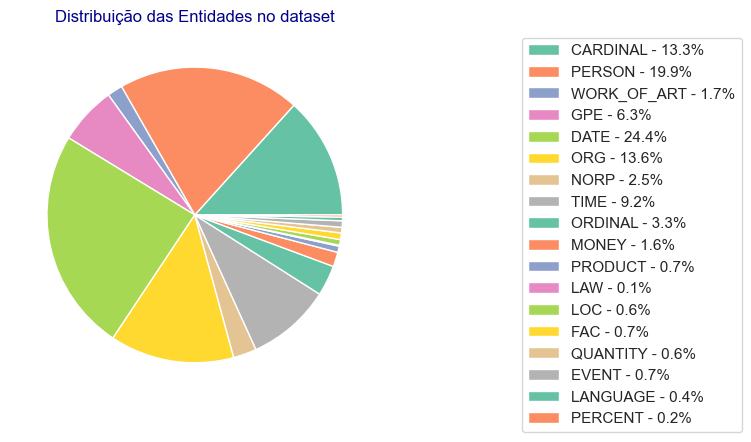

In [275]:
grafico(2)
plt.pie(dfentitycounts['Valores Relativos (%)'])
plt.title('Distribuição das Entidades no dataset', color='Darkblue')
labels = [f"{entidade} - {percent:.1f}%" for entidade, percent in zip(dfentitycounts.index, dfentitycounts['Valores Relativos (%)'])]
plt.legend(labels, loc='upper right', bbox_to_anchor=(2, 1))


In [276]:
sentimento = TextBlob(textounico).sentiment
sentimento

Sentiment(polarity=0.04341975925041178, subjectivity=0.5423556709053837)

In [277]:
print("O nosso dataset é composto por ",data.shape[0]," linhas e",data.shape[1]," colunas")

O nosso dataset é composto por  5838  linhas e 3  colunas


In [278]:
def anonymize_selected_entities(text):
    doc = nlp(text)
    new_tokens = []
    entidades_a_remover = {"CARDINAL", "ORG", "PERSON", "DATE"}
    last_idx = 0
    for ent in doc.ents:
        if ent.label_ in entidades_a_remover:
            new_tokens.append(text[last_idx:ent.start_char])
            last_idx = ent.end_char  
    new_tokens.append(text[last_idx:]) 
    return ''.join(new_tokens)

In [279]:
valid_words = set(nltk_words.words())
def reduce_excessive_repeats_smart(text):
    def reduce_word(word):
        if word.lower() in valid_words:
            return word
        return re.sub(r'(.)\1{2,}', r'\1\1', word)
    return ' '.join(reduce_word(w) for w in text.split())


In [280]:
def remove_repeated_words(text):
    return re.sub(r'\b(\w+)(\s+\1\b)+', r'\1', text, flags=re.IGNORECASE)

In [281]:
def clean_text_spacy(text, additional_stopwords=set()):
    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop       
        and not token.is_punct            
        and not token.like_num               
        and token.text.lower() not in additional_stopwords
    ]
    return ' '.join(tokens)


In [282]:
def split_hashtag(hashtag):
    hashtag_body = hashtag[1:]
    if any(c.isupper() for c in hashtag_body):
        split_text = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', hashtag_body)
        return split_text.lower()
    else:
        split_words = wordninja.split(hashtag_body)
        return " ".join(split_words)
def process_text(text):
    processed_words = []
    for word in text.split():
        if word.startswith('#'):
            processed_words.append(split_hashtag(word))
        else:
            processed_words.append(word)
    return ' '.join(processed_words)

In [283]:
def corrigir_erros_comuns(text):
    correcoes = {
        "luv": "love",
        "gr8": "great",
        "ur": "your",
        "u": "you",
        "r": "are",
        "ya": "you",
        "im": "i am",
        "dont": "do not",
        "cant": "cannot",
        "wont": "will not",
        "idk": "i do not know",
        "omg": "oh my god",
        "wtf": "what the fuck",
        "lmao": "laughing my ass off",
        "lol": "laughing out loud",
        "tho": "though",
        "thx": "thanks",
        "pls": "please",
        "plz": "please",
        "gonna": "going to",
        "wanna": "want to",
        "gotta": "got to",
        "ain't": "is not",
        "cuz": "because",
        "bc": "because",
        "b4": "before",
        "btw": "by the way",
        "omw": "on my way",
        "kinda": "kind of",
        "lemme": "let me",
        "gimme": "give me",
        "smh": "shaking my head",
        "tbh": "to be honest",
        "fuk": "fuck",
        "fukin": "fucking",
        "fuking": "fucking",
        "fuckin": "fucking",
        "ya'll": "you all",
        "yall": "you all",
        "coz": "because",
        "brb": "be right back",
        "afk": "away from keyboard",
        "tldr": "too long didn't read",
        "ikr": "i know right",
        "dm": "direct message"
    }
    for errado, certo in correcoes.items():
        text = re.sub(rf'\b{re.escape(errado)}\b', certo, text)
        return text
    

In [284]:
def substituir_emojis(text):
    return emoji.demojize(text, delimiters=(" ", " "))

In [285]:
def remove_low_tfidf_words(texts, threshold=0.01):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()   
    cleaned_texts = []
    for doc_index, doc in enumerate(texts):
        tfidf_scores = tfidf_matrix[doc_index].toarray().flatten()
        doc_words = doc.split()
        word_tfidf = dict(zip(feature_names, tfidf_scores))
        filtered_words = [word for word in doc_words if word in word_tfidf and word_tfidf[word] >= threshold]       
        cleaned_texts.append(' '.join(filtered_words))
    return cleaned_texts

In [287]:
data = pd.read_excel("Dataset\\datasetlimpo4emocoes_EN.xlsx")
data = data[data['Text'].str.strip() != ""]
data = data.drop_duplicates(subset='Text').reset_index(drop=True)
data

,Text,Emotion,en
0,- great time to think about how to make to our...,Fear,en
1,--- she does wat she want to prove to bitches....,Joy,en
2,!!!1! Merry &amp; a Happy New ! mediale #mindf...,Fear,en
3,""" Don't be cross with Jenny , "" James said alm...",Anger,en
4,"""A betrayal unfolded, leaving behind a bitter ...",Anger,en
...,...,...,...
5833,You're welcome . Did you have a good time on t...,Joy,en
5834,"Youu call it JEALOUSY, I call it of #Losing YO...",Fear,en
5835,YOU'VE PROBABLY HAD DICK FROM 99% OF THE BURTO...,Anger,en
5836,That feeling when your closest friend saw you ...,Sadness,en


In [288]:
nlp = spacy.load("en_core_web_lg")
stop_words = set(stopwords.words('english'))
data['Text'] = data['Text'].astype(str).str.lower()
data['Text'] = data['Text'].str.replace(r'&quot;.*?&quot;', '', regex=True)
data['Text'] = data['Text'].apply(process_text)
data['Text'] = data['Text'].apply(substituir_emojis)
data['Text'] = data['Text'].apply(lambda x: contractions.fix(x))
data['Text'] = data['Text'].apply(fix_text)
data['Text'] = data['Text'].apply(fix)
data['Text'] = data['Text'].apply(corrigir_erros_comuns)
data['Text'] = data['Text'].str.replace(r'\bÃ[\wÂ¢â€™“”]+\b', '', regex=True, case=False)
data['Text'] = data['Text'].str.replace(r'Ã¢Â¬Ã¢Â¬', '', regex=True, case=False)
data['Text'] = data['Text'].str.replace(r'\s+', ' ', regex=True).str.strip()
data['Text'] = data['Text'].str.replace(r'mÃ¬ Ã¬Â²Ã¬Â¶Ã®ÂµÃ¬Â²Ã¬Â£', '', regex=True, case=False)
data['Text'] = data['Text'].str.replace(r'Ã©', 'é', regex=True, case=False)
data['Text'] = data['Text'].str.replace(r'Ã®', 'î', regex=True, case=False)
data['Text'] = data['Text'].str.replace(r'\b&amp\b', '', regex=True)
data['Text'] = data['Text'].str.replace(r'\S+@\S+', ' ', regex=True)
data['Text'] = data['Text'].str.replace(r'@\S+', '', regex=True)
data['Text'] = data['Text'].str.replace(r'http\S+|https\S+|www\S+', '', regex=True)
data['Text'] = data['Text'].str.replace(r'\bomfg\b', '', regex=True, case=False)
data['Text'] = data['Text'].str.replace(r'\d+',  '', regex=True)
data['Text'] = data['Text'].apply(anonymize_selected_entities)
data['Text'] = data['Text'].apply(reduce_excessive_repeats_smart)
data['Text'] = data['Text'].apply(remove_repeated_words)
data['Text'] = data['Text'].apply(lambda x: clean_text_spacy(x, additional_stopwords={'rt','amp', 'rhoa'}))
data['Text'] = remove_low_tfidf_words(data['Text'], threshold=0.01)
data['Text'] = data['Text'].apply(lambda x: re.sub(f"[{re.escape(string.punctuation)}]", " ", x))
data

,Text,Emotion,en
0,great time think world free,Fear,en
1,wat want prove bitch dnt want wat matter hw dr...,Joy,en
2,happy new mediale mind fuck party,Fear,en
3,cross say read mind,Anger,en
4,betrayal unfold leave bitter taste anger disap...,Anger,en
...,...,...,...
5833,welcome good time vacation,Joy,en
5834,youu jealousy lose,Fear,en
5835,probably dick burton population std fugly pare...,Anger,en
5836,feeling close friend see ignore,Sadness,en


In [289]:
emocoeslist = {"Sadness":0, "Joy":1, "Anger":2, "Fear":4}
data['Emotion_num'] = data['Emotion'].map(emocoeslist)
data = data[data['Text'].str.strip() != ""]
data = data[data['Text'].str.split().apply(len) > 1]
data = data.drop_duplicates(subset='Text').reset_index(drop=True)
data

,Text,Emotion,en,Emotion_num
0,great time think world free,Fear,en,4
1,wat want prove bitch dnt want wat matter hw dr...,Joy,en,1
2,happy new mediale mind fuck party,Fear,en,4
3,cross say read mind,Anger,en,2
4,betrayal unfold leave bitter taste anger disap...,Anger,en,2
...,...,...,...,...
5586,welcome good time vacation,Joy,en,1
5587,youu jealousy lose,Fear,en,4
5588,probably dick burton population std fugly pare...,Anger,en,2
5589,feeling close friend see ignore,Sadness,en,0


C:\Users\garci\AppData\Local\Temp\ipykernel_9764\1215207054.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Emotion", data=data,order= data['Emotion'].value_counts().index,palette="husl")


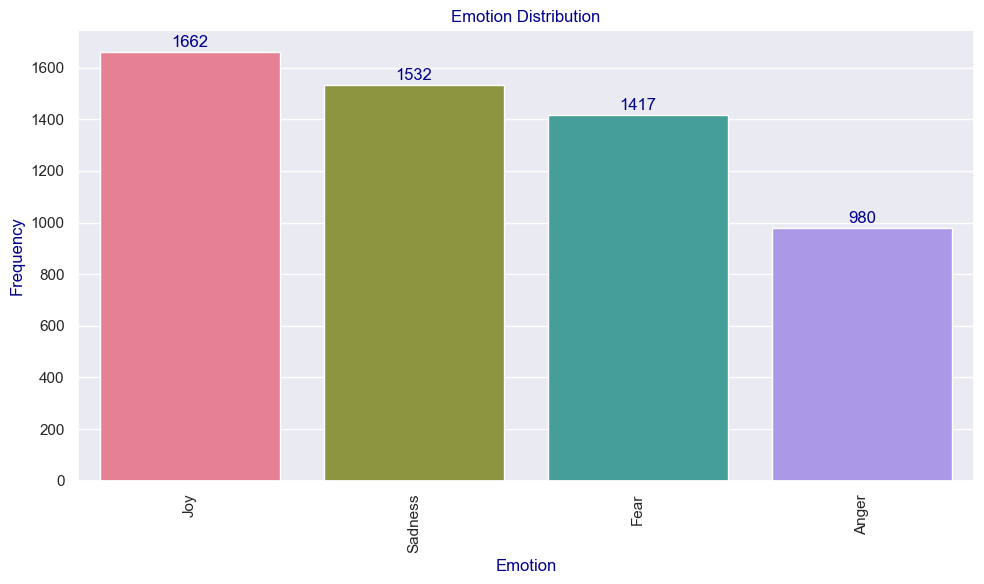

In [290]:
grafico(4)
plt.figure(figsize=(10, 6), dpi=100)
sns.countplot(x="Emotion", data=data,order= data['Emotion'].value_counts().index,palette="husl")
plt.xlabel('Emotion', color="Darkblue")
plt.xticks(rotation=90)
plt.ylabel('Frequency', color='Darkblue')
plt.title('Emotion Distribution', color='Darkblue')
for i, value in enumerate(data['Emotion'].value_counts()):
    plt.text(i, value+20, str(value),ha='center',color='Darkblue')
plt.tight_layout()
plt.show() 

In [291]:
textounico = ' '.join(data['Text'])
len(textounico)

246270

In [292]:
nlp = spacy.load("en_core_web_lg", disable=["ner","parser"])
chunk_size = 1000000
chunks = [textounico[i:i + chunk_size] for i in range(0, len(textounico), chunk_size)]
words2 = []
for chunk in chunks:
    doc = nlp(chunk)
    words2.extend([token.lemma_ for token in doc if not token.is_stop and token.is_alpha and token.ent_type_ == ""])
print(f"Total de palavras processadas: {len(words2)}")

Total de palavras processadas: 36769


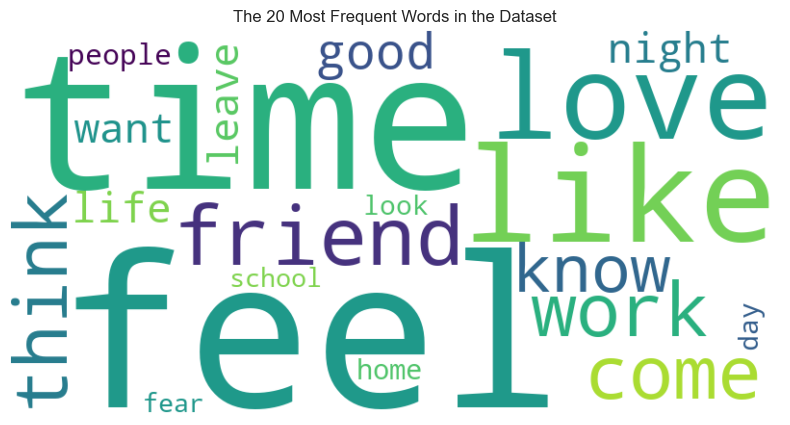

In [293]:
word_frequencies = Counter(words2)
top_20_words = dict(word_frequencies.most_common(20))
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate_from_frequencies(top_20_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("The 20 Most Frequent Words in the Dataset")
plt.show()

In [294]:
sentimento = TextBlob(textounico).sentiment
sentimento

Sentiment(polarity=0.030987286338957386, subjectivity=0.5802858458986576)

In [295]:
data['tokens'] = data['Text'].apply(word_tokenize)

In [296]:
emocoeslist = {"Sadness":0, "Joy":1, "Anger":2, "Fear":4}
data['Emotion_num'] = data['Emotion'].map(emocoeslist)
data

,Text,Emotion,en,Emotion_num,tokens
0,great time think world free,Fear,en,4,"[great, time, think, world, free]"
1,wat want prove bitch dnt want wat matter hw dr...,Joy,en,1,"[wat, want, prove, bitch, dnt, want, wat, matt..."
2,happy new mediale mind fuck party,Fear,en,4,"[happy, new, mediale, mind, fuck, party]"
3,cross say read mind,Anger,en,2,"[cross, say, read, mind]"
4,betrayal unfold leave bitter taste anger disap...,Anger,en,2,"[betrayal, unfold, leave, bitter, taste, anger..."
...,...,...,...,...,...
5586,welcome good time vacation,Joy,en,1,"[welcome, good, time, vacation]"
5587,youu jealousy lose,Fear,en,4,"[youu, jealousy, lose]"
5588,probably dick burton population std fugly pare...,Anger,en,2,"[probably, dick, burton, population, std, fugl..."
5589,feeling close friend see ignore,Sadness,en,0,"[feeling, close, friend, see, ignore]"


In [297]:
data.to_csv("Dataset\\datasetlimpo4emocoes.csv", index=False)


In [298]:
data = pd.read_csv("Dataset\\datasetlimpo4emocoes.csv")
data

,Text,Emotion,en,Emotion_num,tokens
0,great time think world free,Fear,en,4,"['great', 'time', 'think', 'world', 'free']"
1,wat want prove bitch dnt want wat matter hw dr...,Joy,en,1,"['wat', 'want', 'prove', 'bitch', 'dnt', 'want..."
2,happy new mediale mind fuck party,Fear,en,4,"['happy', 'new', 'mediale', 'mind', 'fuck', 'p..."
3,cross say read mind,Anger,en,2,"['cross', 'say', 'read', 'mind']"
4,betrayal unfold leave bitter taste anger disap...,Anger,en,2,"['betrayal', 'unfold', 'leave', 'bitter', 'tas..."
...,...,...,...,...,...
5586,welcome good time vacation,Joy,en,1,"['welcome', 'good', 'time', 'vacation']"
5587,youu jealousy lose,Fear,en,4,"['youu', 'jealousy', 'lose']"
5588,probably dick burton population std fugly pare...,Anger,en,2,"['probably', 'dick', 'burton', 'population', '..."
5589,feeling close friend see ignore,Sadness,en,0,"['feeling', 'close', 'friend', 'see', 'ignore']"


### NB

In [299]:
X,y = data['Text'], data['Emotion_num']
X = X.reset_index(drop=True)  
y = y.reset_index(drop=True)
print(X[0])
print(y[0])

great time think world free
4


In [300]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

In [301]:
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)
X_val_counts = vectorizer.transform(X_val)

In [302]:
model = MultinomialNB()
model.fit(X_train_counts, y_train)

MultinomialNB()

In [303]:
y_pred_test = model.predict(X_test_counts)
y_pred_train = model.predict(X_train_counts)
y_pred_val = model.predict(X_val_counts)

In [304]:
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred_test)

In [305]:
print(f'Training Accuracy: {accuracy_train:.4f}')
print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test F1 Score: {f1_test:.4f}')
print('Test Confusion Matrix:')
print(conf_matrix)
print('Test Classification Report:')
print(classification_report(y_test, y_pred_test))

Training Accuracy: 0.8736
Test Accuracy: 0.6148
Test F1 Score: 0.6166
Test Confusion Matrix:
[[188  75  10  34]
 [ 74 223   8  28]
 [ 31  25 116  24]
 [ 59  49  14 161]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.61      0.57       307
           1       0.60      0.67      0.63       333
           2       0.78      0.59      0.67       196
           4       0.65      0.57      0.61       283

    accuracy                           0.61      1119
   macro avg       0.64      0.61      0.62      1119
weighted avg       0.63      0.61      0.62      1119



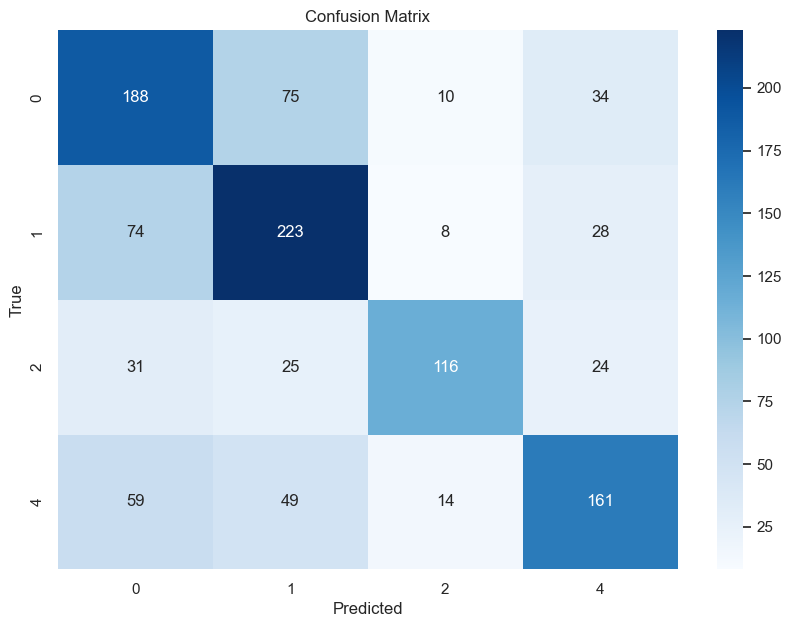

In [306]:
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### NB + LSTM

In [307]:
X,y = data['Text'], data['Emotion_num']
X = X.reset_index(drop=True)  
y = y.reset_index(drop=True)
print(X[0])
print(y[0])

great time think world free
4


In [328]:
with open('Recursos\\X4emo.pickle','wb') as f:
    pickle.dump(X,f)
    
with open('Recursos\\y4emo.pickle','wb') as f:
    pickle.dump(y,f)

In [329]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [330]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

In [331]:
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)
X_val_counts = vectorizer.transform(X_val)

In [332]:
nb_model = MultinomialNB()
nb_model.fit(X_train_counts, y_train)

MultinomialNB()

In [333]:
nb_train_predictions = nb_model.predict_proba(X_train_counts)
nb_test_predictions = nb_model.predict_proba(X_test_counts)
nb_val_predictions = nb_model.predict_proba(X_val_counts)

In [334]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [335]:
max_sequence_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_sequence_length)

In [336]:
input_text = Input(shape=(max_sequence_length,))
embedding = Embedding(input_dim=5000, output_dim=128, input_length=max_sequence_length)(input_text)
lstm = LSTM(128, return_sequences=True)(embedding)
lstm = Dropout(0.5)(lstm)
lstm = LSTM(64)(lstm)
lstm = Dropout(0.5)(lstm)
lstm_output = Dense(64, activation='relu')(lstm)

C:\Users\garci\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [337]:
input_nb = Input(shape=(nb_train_predictions.shape[1],))
nb_output = Dense(64, activation='relu')(input_nb)

In [338]:
combined = concatenate([lstm_output, nb_output])
combined = Dense(64, activation='relu')(combined)
combined = Dropout(0.5)(combined)
final_output = Dense(len(label_encoder.classes_), activation='softmax')(combined)

In [339]:
model = Model(inputs=[input_text, input_nb], outputs=final_output)

In [340]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [341]:
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max')
checkpoint = ModelCheckpoint("best_cnn_model.keras", monitor='val_accuracy', save_best_only=True, mode='max')
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [342]:
history = model.fit([X_train_pad, nb_train_predictions], y_train, epochs=20, batch_size=32, validation_data=([X_test_pad, nb_test_predictions], y_test),
          callbacks=[early_stop, lr_reduce, checkpoint])

Epoch 1/20


C:\Users\garci\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_39', 'keras_tensor_46']. Received: the structure of inputs=('*', '*')
  warnings.warn(


105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.6674 - loss: 1.1086 - val_accuracy: 0.6104 - val_loss: 1.0106 - learning_rate: 0.0010
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.8762 - loss: 0.4317 - val_accuracy: 0.6032 - val_loss: 1.1572 - learning_rate: 0.0010
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8645 - loss: 0.4053
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.8645 - loss: 0.4052 - val_accuracy: 0.6086 - val_loss: 1.1802 - learning_rate: 0.0010
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.8837 - loss: 0.3699 - val_accuracy: 0.5987 - val_loss: 1.2287 - learning_rate: 5.0000e-04
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8763 - loss: 0.4024
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.8763 - loss: 0.4022 - v

In [343]:
train_loss, train_accuracy = model.evaluate([X_train_pad, nb_train_predictions], y_train)
test_loss, test_accuracy = model.evaluate([X_test_pad, nb_test_predictions], y_test)
val_loss, val_accuracy = model.evaluate([X_val_pad, nb_val_predictions], y_val)

105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8835 - loss: 0.4071
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5988 - loss: 1.0461
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6256 - loss: 1.0066


In [344]:
y_pred_test = np.argmax(model.predict([X_test_pad, nb_test_predictions]), axis=1)


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


In [345]:
f1_test = f1_score(y_test, y_pred_test, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred_test)

In [346]:
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1 Score: {f1_test:.4f}')
print('Test Confusion Matrix:')
print(conf_matrix)
print('Test Classification Report:')
print(classification_report(y_test, y_pred_test))

Training Accuracy: 0.8804
Test Accuracy: 0.6104
Test F1 Score: 0.6122
Test Confusion Matrix:
[[195  66  13  33]
 [ 83 204  13  33]
 [ 35  17 120  24]
 [ 60  40  19 164]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.64      0.57       307
           1       0.62      0.61      0.62       333
           2       0.73      0.61      0.66       196
           3       0.65      0.58      0.61       283

    accuracy                           0.61      1119
   macro avg       0.63      0.61      0.62      1119
weighted avg       0.62      0.61      0.61      1119



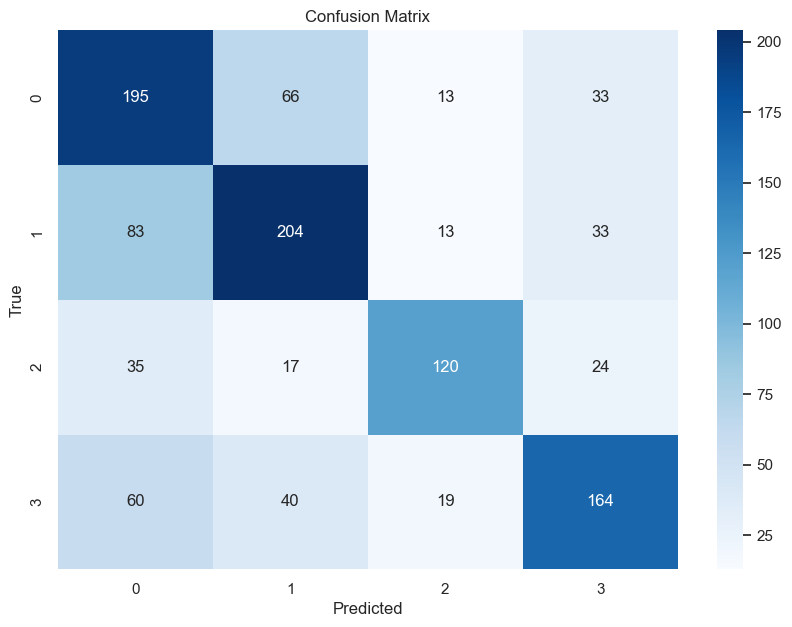

In [347]:
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()